In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scanpy as sc
from scipy.cluster.hierarchy import fcluster
from scipy.stats import mode
from matplotlib.patches import Patch

In [69]:
sample_name = "SPECTRUM_OV008"
# experiment_id = "SHAH_H000005_T03_05_DLP01"
# signals_path = "/data1/shahs3/isabl_data_lake/analyses/46/16/44616/results/hscn.csv.gz"
# hmmcopy_path = "/data1/shahs3/isabl_data_lake/analyses/45/20/44520/results/SHAH_H000005_T03_05_DLP01_hmmcopy_reads.csv.gz"
annot_path = "/data1/shahs3/users/myersm2/spectrum-dlp-pipeline/v5.2/postprocessing/v5-aggregated_anndatas/SPECTRUM-OV-008_cna.h5"

## Global Helper Functions

In [4]:
# Combining small clusters into one arbitrarily

def safe_mode(x):
    m = mode(x, nan_policy="omit", keepdims=False)

    # m.mode and m.count could be scalars or arrays depending on scipy version and input
    if m.count is not None:
        count_val = m.count if np.isscalar(m.count) else m.count[0]
        if count_val > 0:
            return m.mode if np.isscalar(m.mode) else m.mode[0]

    return np.nan

def get_cnv_profile(state_matrix, cluster_label_df):
    state_matrix_clusters = state_matrix.copy()
    state_matrix_clusters['cluster'] = cluster_label_df['cluster']
    cluster_profiles = (
        state_matrix_clusters.groupby("cluster").agg(safe_mode)
    )
    if "cluster" in cluster_profiles.columns:
        cluster_profiles = cluster_profiles.drop(columns=["cluster"])
    
    cluster_profiles = cluster_profiles.reset_index()

    cell_counts = state_matrix_clusters.groupby("cluster").size()
    cluster_profiles['cell_count'] = cluster_profiles['cluster'].map(cell_counts)
    
    return cluster_profiles

def format_cnv_profile(cluster_profiles, bin_df, value = "state"):
    # Melt to long format
    profile_df = cluster_profiles.melt(id_vars=["cluster", "cell_count"],
                                       var_name="bin_id", value_name=value)

    merged_cluster_profiles_lst = []
    cluster_cell_count_df = cluster_profiles[["cluster", "cell_count"]].drop_duplicates()
    for cluster, cell_count in cluster_cell_count_df.itertuples(index=False):
        cluster_bin_df = bin_df.copy()
        cluster_bin_df["cluster"] = cluster
        cluster_bin_df["cell_count"] = cell_count
        cluster_profile_df = profile_df[profile_df["cluster"] == cluster].drop(columns=["cluster", "cell_count"])
        cluster_merged_profile_df = cluster_profile_df.merge(cluster_bin_df, on = "bin_id", how="right")
        cluster_merged_profile_df[value] = cluster_merged_profile_df[value].fillna(0).astype(int)
        merged_cluster_profiles_lst.append(cluster_merged_profile_df)
    merged_profile_df = pd.concat(merged_cluster_profiles_lst, ignore_index=True)

    # Rename and sort
    merged_profile_df = merged_profile_df.rename(columns={"cluster": "clone"})
    merged_profile_df = merged_profile_df.sort_values(by=["clone", "chr", "start"]).reset_index(drop=True)

    # Identify runs of same state and chromosome
    merged_profile_df["state_change"] = (
        (merged_profile_df[value] != merged_profile_df.groupby("clone")[value].shift()) |
        (merged_profile_df["chr"] != merged_profile_df.groupby("clone")["chr"].shift())
    ).astype(int)
    merged_profile_df["run_id"] = merged_profile_df.groupby("clone")["state_change"].cumsum()

    # Collapse
    collapsed = merged_profile_df.groupby(["clone", "chr", "run_id", value, "cell_count"], as_index=False).agg({
        "start": "min",
        "end": "max"
    })

    if value == "state":
        collapsed["copy_number"] = collapsed[value].astype(int) + 2
    elif value == "copy_number":
        collapsed["state"] = collapsed[value].astype(int) - 2
    collapsed["size"] = collapsed["end"] - collapsed["start"]

    final = collapsed[["clone", "chr", "start", "end", "copy_number", "state", "size", "cell_count"]]
    final = final.sort_values(by=["clone", "chr", "start"]).reset_index(drop=True)

    return final

def chr_sort_key(x):
    try:
        return int(x)
    except ValueError:
        # Handle 'X', 'Y', 'MT', etc., by mapping them to higher values
        chr_map = {"X": 23, "Y": 24, "MT": 25}
        return chr_map.get(x.upper(), 99)



## Based on SIGNALS

In [96]:
def long_to_cell_bin_matrix(df, select_chr = None, value_col="state"):
    """
    Converts long-format bin-level data to a matrix with cells as rows and bins as columns.

    Parameters:
    - df: DataFrame with 'chr', 'start', 'end', 'cell_id', and the value_col.
    - value_col: Column to use as matrix values (e.g., 'reads', 'state').

    Returns:
    - A pivoted DataFrame with cells as rows and bins as columns.
    """

    # Construct bin label
    if select_chr is not None:
        df = df[df['chr'].isin(select_chr)]
    df['bin_id'] = df['chr'].astype(str) + ":" + df['start'].astype(str) + "-" + df['end'].astype(str)

    # Pivot
    matrix = df.pivot(index='cell_id', columns='bin_id', values=value_col)
    matrix.columns.name = None

    # Sort columns by chr and start coordinate
    def chr_sort_key(x):
        chrom, start = x.split(":")
        try:
            chrom_val = int(chrom)
        except ValueError:
            # Map X, Y, MT to higher values for sorting
            chrom_map = {"X": 23, "Y": 24, "MT": 25}
            chrom_val = chrom_map.get(chrom.upper(), 26)
        return (chrom_val, int(start.split("-")[0]))

    sorted_cols = sorted(matrix.columns, key=chr_sort_key)
    matrix = matrix[sorted_cols]

    return matrix


state_colors = {
    "-2": "#2C78B2",  # Dark blue
    "-1": "#94C4DB",  # Light blue
    "0": "#C5C5C5",  # Gray
    "1": "#FCC484",  # Light orange
    "2": "#FA8154",  # Orange
    "3": "#DD4031",  # Red-orange
    "4": "#A9000D",  # Dark red
    "5": "#8C033A",  # Burgundy
    "6": "#6A1B9A",  # Medium purple
    "7": "#4A148C",  # Dark purple
    "8": "#38006B",  # Very dark purple
    "9": "#2E0057",  # Deep purple
    "10": "#240043",  # Almost black purple
    "11": "#1A002F",  # Darkest purple
    "12": "#12001C",  # Near-black purple
}

def plot_signals_state_heatmap(matrix, state_colors = state_colors, cell_clone_annots = None,
                       title="HMM Copy States", cluster_t = 4):
    """
    Plots a heatmap using a custom colormap for HMM states.
    
    Parameters:
    - matrix: DataFrame with cells as rows, bins as columns
    - state_colors: dict mapping state (as str or int) to color hex codes
    - title: Title of the plot
    """
    # Ensure matrix has integer states, not strings
    matrix = matrix.astype(int)

    # Sort colors by integer state value
    sorted_states = sorted(int(k) for k in state_colors.keys())
    color_list = [state_colors[str(k)] for k in sorted_states]

    # Create colormap and normalization
    state_cmap = mcolors.ListedColormap(color_list)
    norm = mcolors.BoundaryNorm(boundaries=[s - 0.5 for s in sorted_states] + [sorted_states[-1] + 0.5], ncolors=len(color_list))

    init_cluster_plt = sns.clustermap(matrix, cmap = state_cmap)
    linkage = init_cluster_plt.dendrogram_row.linkage
    cluster_labels = fcluster(linkage, t = cluster_t, criterion = 'maxclust')
    plt.close()

    row_colors_series = pd.Series(cluster_labels, index=matrix.index)
    palette = sns.color_palette("hls", len(set(cluster_labels)))
    lut = dict(zip(sorted(set(cluster_labels)), palette))
    row_colors = row_colors_series.map(lut)

    # Plot
    plt.figure(figsize=(12, 8))
    cluster_plt = sns.clustermap(
        matrix,
        cmap = state_cmap,
        cbar_pos = (1.03, 0.6, 0.03, 0.2),
        cbar_kws = {"label": "HMM State"},
        row_cluster = True,
        col_cluster = False,
        row_colors = row_colors,
        dendrogram_ratio = (0.01, 0.01),
        xticklabels = False,
        yticklabels = False
    )
    cluster_plt.ax_heatmap.set_ylabel("Cells")
    cluster_plt.ax_heatmap.set_xlabel("Bins")

    handles = [Patch(color=lut[i], label=f"Cluster {i}") for i in lut]
    plt.legend(handles=handles, bbox_to_anchor=(1, 1), title="Row Clusters", loc='lower left')

    plt.show()

    return row_colors_series


In [97]:
signals_df = pd.read_csv(signals_path)
signals_matrix = long_to_cell_bin_matrix(signals_df)

print(signals_matrix.shape)
signals_df.head()

(572, 4375)


,cell_id,chr,start,end,map,copy,state,alleleA,alleleB,totalcounts,...,state_min,A,B,state_AS_phased,state_AS,LOH,phase,state_phase,state_BAF,bin_id
0,A96167B-R54-C10,1,2000001,2500000,0.997066,1.581973,2,11.0,7.0,18.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:2000001-2500000
1,A96167B-R54-C10,1,3000001,3500000,0.996989,1.802632,2,12.0,10.0,22.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:3000001-3500000
2,A96167B-R54-C10,1,4000001,4500000,0.996234,2.434460,2,17.0,13.0,30.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:4000001-4500000
3,A96167B-R54-C10,1,4500001,5000000,0.999002,2.499939,2,26.0,20.0,46.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:4500001-5000000
4,A96167B-R54-C10,1,5000001,5500000,0.997099,2.391556,2,6.0,10.0,16.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:5000001-5500000


/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

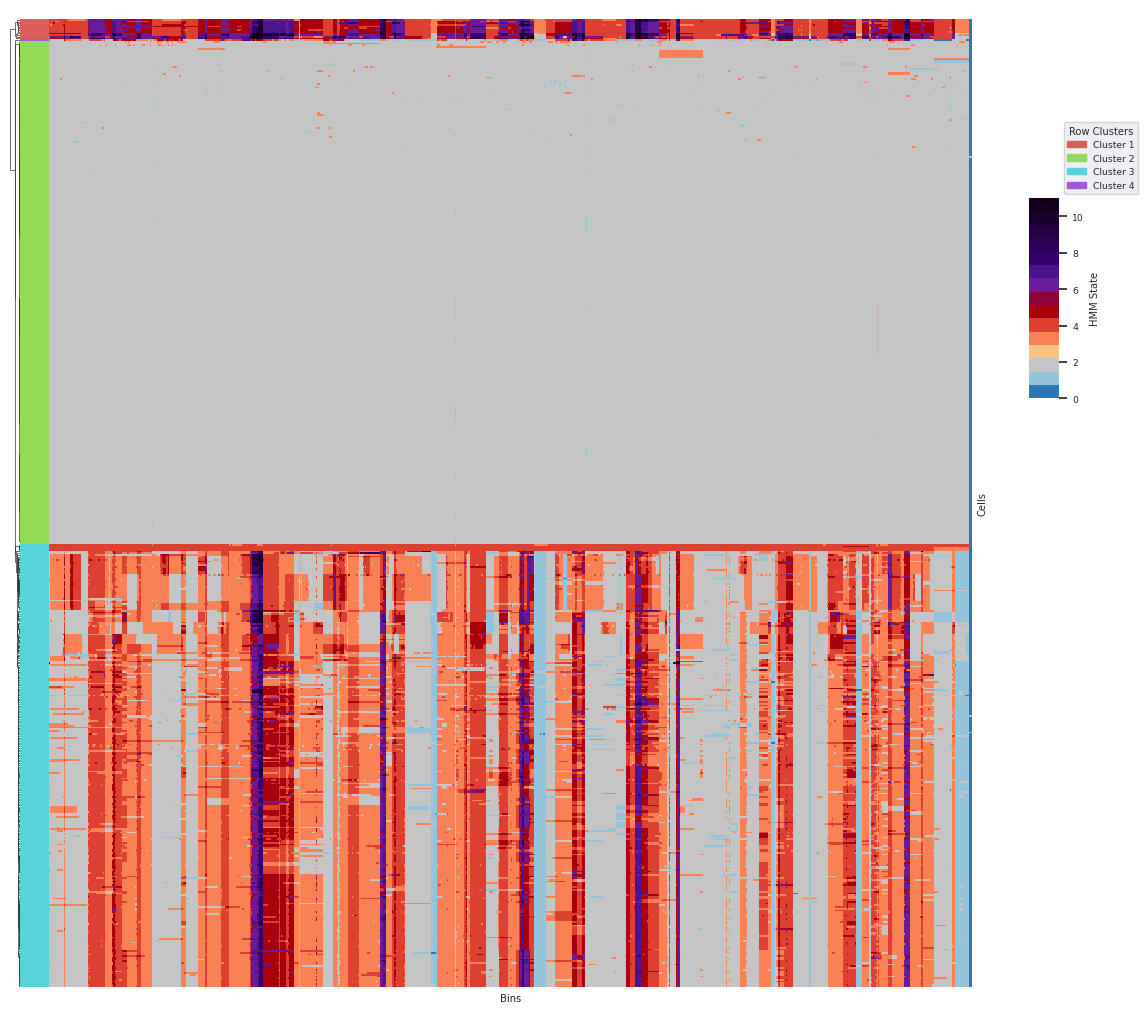

In [98]:
signals_clusters = plot_signals_state_heatmap(signals_matrix, 
                                      cell_clone_annots = cell_clone_annots,
                                      title="HMM Copy States Heatmap for Chromosomes 1 and 2", cluster_t = 4)

[2 3 1 4]
275
(275, 4375)


/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

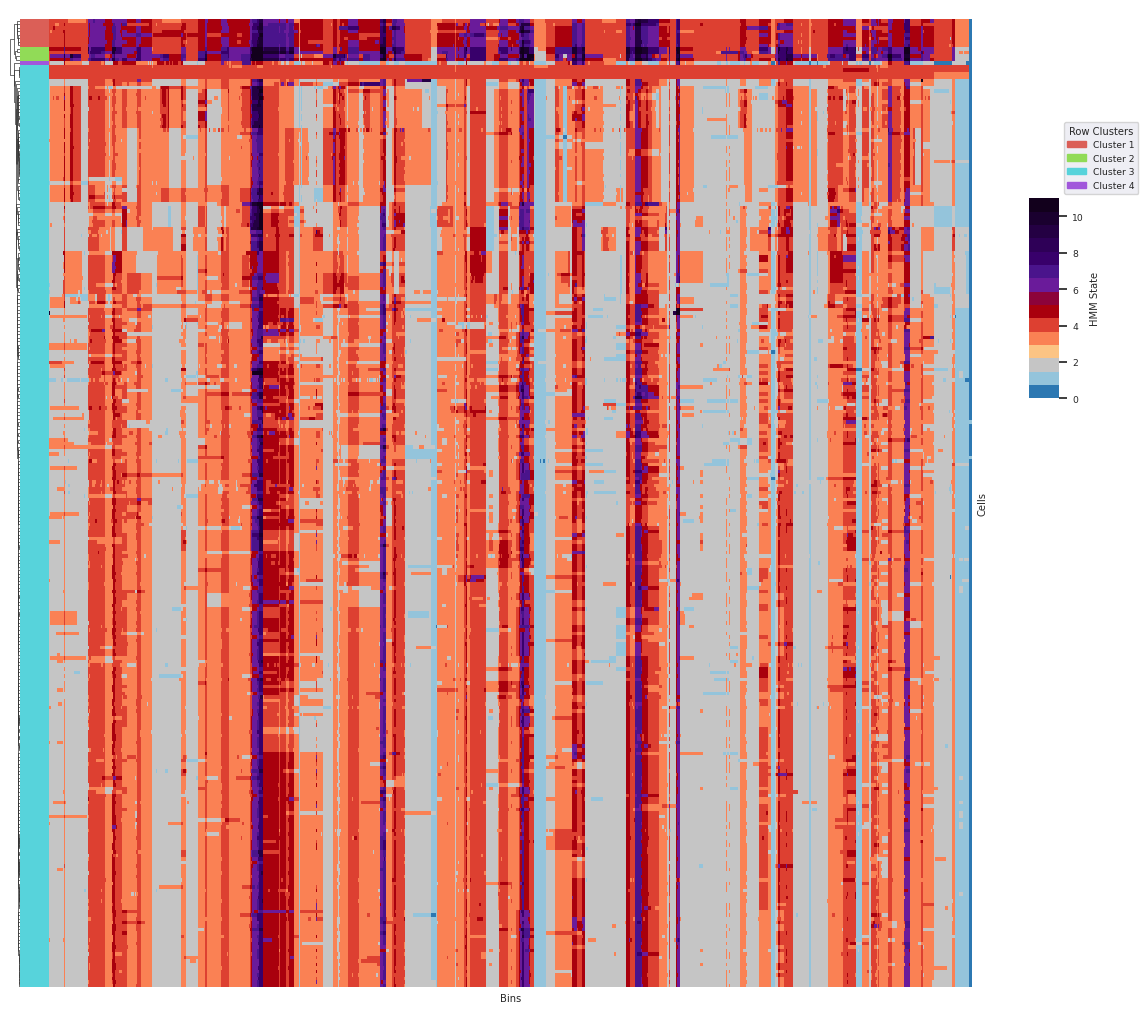

cell_id
A96123A-R21-C09    3
A96123A-R21-C14    3
A96123A-R21-C17    3
A96123A-R21-C22    3
A96123A-R21-C36    3
                  ..
A96167B-R53-C46    1
A96167B-R53-C63    3
A96167B-R54-C30    3
A96167B-R56-C33    3
A96167B-R57-C19    3
Length: 275, dtype: int32

In [100]:
print(signals_clusters.unique())

# Remove normal cells
abnormal_signals_clusters = signals_clusters[signals_clusters != 2]
# Filter matrix to only include abnormal cells
abnormal_cells = signals_clusters.index[signals_clusters != 2]
print(len(abnormal_cells))
abnormal_cells_matrix = signals_matrix.loc[abnormal_cells]
print(abnormal_cells_matrix.shape)

plot_signals_state_heatmap(abnormal_cells_matrix, title="HMM Copy States Heatmap for Abnormal Cells", cluster_t = 4)

In [102]:
clusters_df = pd.DataFrame({
    "cell_id": abnormal_cells_matrix.index,
    "cluster": abnormal_signals_clusters
})
clusters_df['cluster'] = clusters_df['cluster'].replace({1: 0, 2: 0, 3: 1, 4: 0})
clusters_df = clusters_df.set_index("cell_id").loc[abnormal_cells_matrix.index]

In [101]:
abnormal_cells_matrix

,1:2000001-2500000,1:3000001-3500000,1:4000001-4500000,1:4500001-5000000,1:5000001-5500000,1:5500001-6000000,1:6000001-6500000,1:6500001-7000000,1:7000001-7500000,1:7500001-8000000,...,Y:14000001-14500000,Y:14500001-15000000,Y:16500001-17000000,Y:17000001-17500000,Y:17500001-18000000,Y:18000001-18500000,Y:18500001-19000000,Y:20500001-21000000,Y:21000001-21500000,Y:21500001-22000000
cell_id,,,,,,,,,,,,,,,,,,,,,
A96123A-R21-C09,2,2,2,2,2,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
A96123A-R21-C14,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
A96123A-R21-C17,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
A96123A-R21-C22,2,2,2,2,2,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
A96123A-R21-C36,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A96167B-R53-C46,4,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,0,0
A96167B-R53-C63,2,2,2,2,2,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
A96167B-R54-C30,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0


In [104]:
cluster_profiles = get_cnv_profile(abnormal_cells_matrix, clusters_df)
cluster_profiles.head()

,cluster,1:2000001-2500000,1:3000001-3500000,1:4000001-4500000,1:4500001-5000000,1:5000001-5500000,1:5500001-6000000,1:6000001-6500000,1:6500001-7000000,1:7000001-7500000,...,Y:14500001-15000000,Y:16500001-17000000,Y:17000001-17500000,Y:17500001-18000000,Y:18000001-18500000,Y:18500001-19000000,Y:20500001-21000000,Y:21000001-21500000,Y:21500001-22000000,cell_count
0,0,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,0,13
1,1,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,262


In [105]:
bins_df = pd.read_csv("/data1/shahs3/users/sunge/cnv_simulator/data/refs_2/GRCh37_gcwig_bins.csv")
bins_df['bin_id'] = bins_df['chr'].astype(str) + ":" + bins_df['start'].astype(str) + "-" + bins_df['end'].astype(str)

cnv_profile = format_cnv_profile(cluster_profiles, bins_df)

cnv_profile.head()

,clone,chr,start,end,copy_number,state,size,cell_count
0,0,1,1,2000000,2,0,1999999,13
1,0,1,2000001,2500000,6,4,499999,13
2,0,1,2500001,3000000,2,0,499999,13
3,0,1,3000001,3500000,6,4,499999,13
4,0,1,3500001,4000000,2,0,499999,13


In [ ]:
import os

sample_name = "SPECTRUM_OV003"

sample_dir = f"/data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/{sample_name}"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
cnv_profile.to_csv(f"{sample_dir}/{sample_name}_cnv_profile.tsv", 
                   sep = "\t", index=False)

## Based on anndata

In [70]:
clone_annots = sc.read(annot_path)

cell_clone_annots = clone_annots.obs[["sbmclone_cluster_id"]]
cell_clone_annots.index = cell_clone_annots.index.astype(str).str.split("-").str[-3:].str.join("-")
cell_clone_annots = pd.DataFrame(cell_clone_annots).reset_index()

cell_clone_annots

,cell_id,sbmclone_cluster_id
0,128696A-R13-C17,0
1,128696A-R13-C19,0
2,128696A-R13-C20,0
3,128696A-R13-C50,0
4,128696A-R13-C52,0
...,...,...
156,128696A-R32-C46,0
157,128696A-R32-C49,0
158,128696A-R32-C52,0
159,128696A-R32-C54,1


In [71]:
cn_colors = {
    "0": "#2C78B2",  # Dark blue
    "1": "#94C4DB",  # Light blue
    "2": "#C5C5C5",  # Gray
    "3": "#FCC484",  # Light orange
    "4": "#FA8154",  # Orange
    "5": "#DD4031",  # Red-orange
    "6": "#A9000D",  # Dark red
    "7": "#8C033A",  # Burgundy
    "8": "#6A1B9A",  # Medium purple
    "9": "#4A148C",  # Dark purple
    "10": "#38006B",  # Very dark purple
    "11": "#2E0057",  # Deep purple
    "12": "#240043",  # Almost black purple
    "13": "#1A002F",  # Darkest purple
    "14": "#12001C",  # Near-black purple
}

import matplotlib.patches as mpatches

def chr_sort_key(chr_val):
    try:
        return int(chr_val)
    except ValueError:
        # Handle 'X', 'Y', 'MT', etc., by mapping them to higher values
        chr_map = {"X": 23, "Y": 24, "MT": 25, "M": 25}
        return chr_map.get(chr_val.upper(), 99)

def plot_anndata_heatmap(adata, layer="state", state_colors=None, clone_key="sbmclone_cluster_id", title="HMM State Heatmap"):
    """
    Plots a heatmap from an AnnData object using a discrete colormap for integer copy states,
    with optional clone-based row coloring, chromosome boundary lines, labels, and custom legend.
    """
    # 1. Extract matrix
    matrix = adata.layers[layer] if layer in adata.layers else adata.X
    matrix = pd.DataFrame(matrix, index=adata.obs_names, columns=adata.var_names).astype(int)

    # 2. Order columns by chr/start/end
    if {"chr", "start", "end"}.issubset(adata.var.columns):
        var_df = adata.var.assign(col=adata.var_names).copy()
        var_df["chr"] = var_df["chr"].astype(str)
        var_df["chr_sort"] = var_df["chr"].map(chr_sort_key)
        var_df = var_df.sort_values(by=["chr_sort", "start", "end"])

        matrix = matrix[var_df["col"]]

        chroms = var_df["chr"].values
        prev_chr = chroms[0]
        start_idx = 0
        chr_labels = []
        chr_ticks = []
        chr_boundaries = []

        for i in range(1, len(chroms)):
            if chroms[i] != prev_chr:
                midpoint = (start_idx + i - 1) // 2
                chr_labels.append(prev_chr)
                chr_ticks.append(midpoint)
                chr_boundaries.append(i)
                prev_chr = chroms[i]
                start_idx = i

        # Last chromosome
        midpoint = (start_idx + len(chroms) - 1) // 2
        chr_labels.append(prev_chr)
        chr_ticks.append(midpoint)

    # 3. Clone row colors (if clone_key is present)
    row_colors = None
    if clone_key in adata.obs.columns:
        clone_labels = adata.obs[clone_key].astype(str)
        matrix["clone"] = clone_labels.values
        matrix = matrix.sort_values("clone")
        clone_labels = matrix["clone"]
        matrix = matrix.drop(columns="clone")

        unique_clones = sorted(clone_labels.unique())
        palette = sns.color_palette("tab10", n_colors=len(unique_clones))
        clone_color_map = {clone: palette[i] for i, clone in enumerate(unique_clones)}
        row_colors = clone_labels.map(clone_color_map)

    # 4. Colormap setup
    sorted_states = sorted(int(k) for k in state_colors.keys())
    color_list = [state_colors[str(k)] for k in sorted_states]
    cmap = mcolors.ListedColormap(color_list)
    norm = mcolors.BoundaryNorm(
        boundaries=[s - 0.5 for s in sorted_states] + [sorted_states[-1] + 0.5],
        ncolors=len(sorted_states)
    )

    # 5. Plot
    # plt.figure(figsize=(8, 4))
    cluster_plt = sns.clustermap(
        matrix,
        figsize = (10, 6),
        cmap=cmap,
        norm=norm,
        row_colors=row_colors,
        cbar_pos=None,  # We use a manual legend instead
        row_cluster=False,
        col_cluster=False,
        xticklabels=False,
        yticklabels=False,
        dendrogram_ratio=(0.01, 0.01),
    )

    # 6. Add chromosome boundary lines
    for boundary in chr_boundaries:
        cluster_plt.ax_heatmap.axvline(x=boundary, color="white", linewidth=1)

    # 7. Add chromosome labels
    cluster_plt.ax_heatmap.set_xticks(chr_ticks)
    cluster_plt.ax_heatmap.set_xticklabels(chr_labels, fontsize=8)

    cluster_plt.ax_heatmap.set_ylabel("Cells")
    cluster_plt.fig.suptitle(title, y=1.02)

    # 8. Custom legend for HMM states
    legend_patches = [
        mpatches.Patch(color=state_colors[str(k)], label=f"State {k}")
        for k in sorted_states
    ]
    cluster_plt.ax_heatmap.legend(
        handles=legend_patches,
        title="HMM States",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    plt.show()


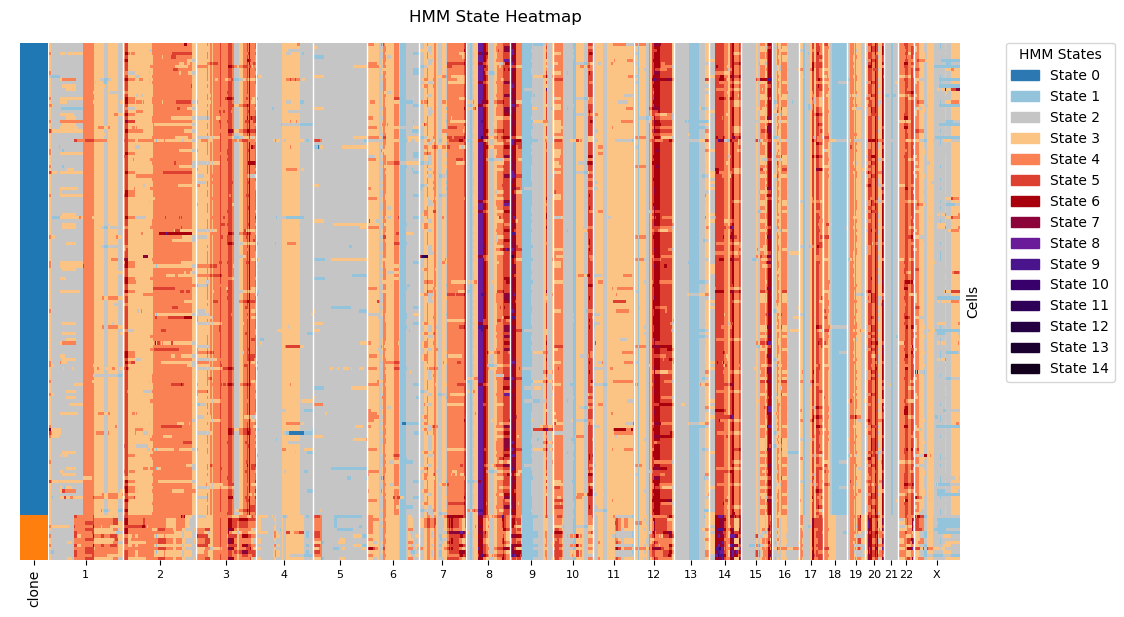

In [72]:
plot_anndata_heatmap(clone_annots, state_colors = cn_colors)

In [73]:
# Extract the state matrix from the AnnData object
anndata_state_matrix = clone_annots.layers["state"].astype(int)
anndata_state_matrix = pd.DataFrame(anndata_state_matrix, index=clone_annots.obs_names, columns=clone_annots.var_names)
anndata_state_matrix = anndata_state_matrix.reindex(sorted(anndata_state_matrix.columns, key=chr_sort_key), axis=1)

# Convert cell IDs to a consistent format
anndata_state_matrix.index = anndata_state_matrix.index.astype(str).str.split("-").str[-3:].str.join("-")

# Create a DataFrame for cell-clone annotations
anndata_clone_df = clone_annots.obs[["sbmclone_cluster_id"]].copy().reset_index().rename(columns={"sbmclone_cluster_id": "cluster"})
anndata_clone_df["cell_id"] = anndata_clone_df["cell_id"].astype(str).str.split("-").str[-3:].str.join("-")
anndata_clone_df = anndata_clone_df.set_index("cell_id").loc[anndata_state_matrix.index]

print(anndata_clone_df)
anndata_state_matrix

                cluster
cell_id                
128696A-R13-C17       0
128696A-R13-C19       0
128696A-R13-C20       0
128696A-R13-C50       0
128696A-R13-C52       0
...                 ...
128696A-R32-C46       0
128696A-R32-C49       0
128696A-R32-C52       0
128696A-R32-C54       1
128696A-R32-C57       0

[161 rows x 1 columns]


,1:1-500000,1:500001-1000000,1:1000001-1500000,1:1500001-2000000,1:2000001-2500000,1:2500001-3000000,1:3000001-3500000,1:3500001-4000000,1:4000001-4500000,1:4500001-5000000,...,X:150500001-151000000,X:151000001-151500000,X:151500001-152000000,X:152000001-152500000,X:152500001-153000000,X:153000001-153500000,X:153500001-154000000,X:154000001-154500000,X:154500001-155000000,X:155000001-155500000
cell_id,,,,,,,,,,,,,,,,,,,,,
128696A-R13-C17,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
128696A-R13-C19,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
128696A-R13-C20,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
128696A-R13-C50,4,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
128696A-R13-C52,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128696A-R32-C46,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
128696A-R32-C49,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
128696A-R32-C52,3,3,3,3,3,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,4


In [75]:
clone_cnv_profile = get_cnv_profile(anndata_state_matrix, anndata_clone_df)
clone_cnv_profile

/tmp/ipykernel_2181693/3579818111.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_matrix_clusters.groupby("cluster").agg(safe_mode)
/tmp/ipykernel_2181693/3579818111.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = state_matrix_clusters.groupby("cluster").size()


,cluster,1:1-500000,1:500001-1000000,1:1000001-1500000,1:1500001-2000000,1:2000001-2500000,1:2500001-3000000,1:3000001-3500000,1:3500001-4000000,1:4000001-4500000,...,X:151000001-151500000,X:151500001-152000000,X:152000001-152500000,X:152500001-153000000,X:153000001-153500000,X:153500001-154000000,X:154000001-154500000,X:154500001-155000000,X:155000001-155500000,cell_count
0,0,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,147
1,1,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,14


In [76]:

def plot_cnv_matrix_heatmap(df, state_colors, title="CNV Heatmap"):
    """
    Plots a CNV heatmap with discrete states and colored cluster rows.

    Parameters:
    - df: DataFrame where 'cluster' is the first column and 'cell_count' is the last column.
    - state_colors: dict mapping CNV state (as str) to color hex codes.
    - title: plot title.
    """
    # Extract cluster labels and matrix
    cluster_labels = df["cluster"].astype(str)
    matrix = df.drop(columns=["cluster", "cell_count"])

    # Assign colors
    unique_clusters = sorted(cluster_labels.unique())
    cluster_palette = sns.color_palette("tab10", len(unique_clusters))
    cluster_color_map = {cl: cluster_palette[i] for i, cl in enumerate(unique_clusters)}

    # Map cluster labels to colors (ensure same index as matrix)
    row_colors = cluster_labels.loc[matrix.index].map(cluster_color_map).values

    # Sort columns by chromosome and start coordinate
    def chr_sort_key(x):
        chrom, start = x.split(":")
        try:
            chrom_val = int(chrom)
        except ValueError:
            chrom_map = {"X": 23, "Y": 24, "MT": 25, "M": 25}
            chrom_val = chrom_map.get(chrom.upper(), 26)
        return (chrom_val, int(start.split("-")[0]))

    sorted_cols = sorted(matrix.columns, key=chr_sort_key)
    matrix = matrix[sorted_cols]

    # Extract chromosome labels from bin names
    bin_cols = matrix.columns
    chroms = [col.split(":")[0] for col in bin_cols]
    prev_chr = chroms[0]
    start_idx = 0
    chr_labels = []
    chr_ticks = []
    chr_boundaries = []

    for i in range(1, len(chroms)):
        if chroms[i] != prev_chr:
            midpoint = (start_idx + i - 1) // 2
            chr_labels.append(prev_chr)
            chr_ticks.append(midpoint)
            chr_boundaries.append(i)
            prev_chr = chroms[i]
            start_idx = i
    midpoint = (start_idx + len(chroms) - 1) // 2
    chr_labels.append(prev_chr)
    chr_ticks.append(midpoint)

    # Prepare colormap for CNV states
    sorted_states = sorted(int(k) for k in state_colors.keys())
    color_list = [state_colors[str(k)] for k in sorted_states]
    cmap = mcolors.ListedColormap(color_list)
    norm = mcolors.BoundaryNorm(
        boundaries=[s - 0.5 for s in sorted_states] + [sorted_states[-1] + 0.5],
        ncolors=len(sorted_states)
    )

    # Plot heatmap
    g = sns.clustermap(
        matrix,
        figsize=(10, 4),
        cmap=cmap,
        norm=norm,
        row_colors=row_colors,
        row_cluster=False,
        col_cluster=False,
        xticklabels=False,
        yticklabels=False,
        dendrogram_ratio=(0.01, 0.01),
        cbar_pos=None
    )

    # Chromosome boundary lines
    for boundary in chr_boundaries:
        g.ax_heatmap.axvline(x=boundary, color="white", linewidth=1)

    # Chromosome labels
    g.ax_heatmap.set_xticks(chr_ticks)
    g.ax_heatmap.set_xticklabels(chr_labels, fontsize=8)
    g.ax_heatmap.set_ylabel("Clusters")
    g.fig.suptitle(title, y=1.02)

    # Add CNV state legend
    state_legend = [
        mpatches.Patch(color=state_colors[str(k)], label=f"State {k}")
        for k in sorted_states
    ]
    g.ax_heatmap.legend(
        handles=state_legend,
        title="CNV States",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.0
    )

    # Add cluster legend
    cluster_legend = [
        mpatches.Patch(color=cluster_color_map[cl], label=f"Cluster {cl}")
        for cl in unique_clusters
    ]
    g.ax_row_dendrogram.legend(
        handles=cluster_legend,
        title="Clusters",
        bbox_to_anchor=(1.05, 0.5),
        loc='center left',
        borderaxespad=0.0
    )

    plt.show()


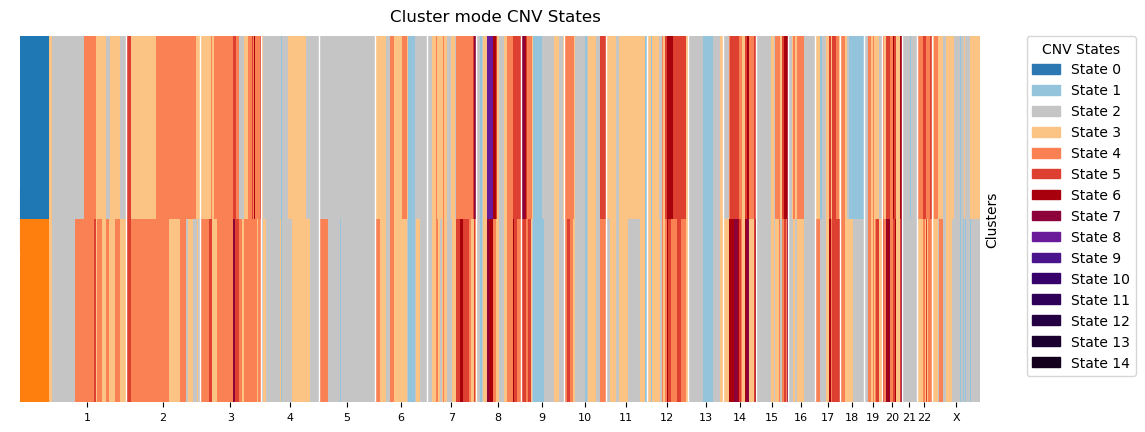

In [77]:
plot_cnv_matrix_heatmap(clone_cnv_profile, state_colors=cn_colors, title="Cluster mode CNV States")

/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_2181693/1912244598.py:24: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


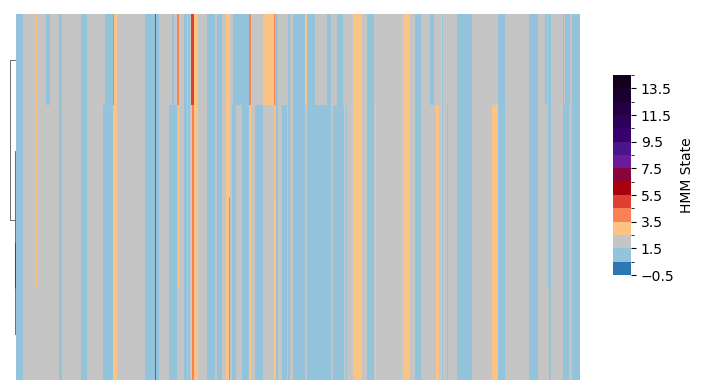

In [26]:
clone_cnv_profile_counts = clone_cnv_profile.copy()
clone_cnv_profile_counts.drop(columns = ["cluster", "cell_count"], inplace=True)

# 4. Colormap setup
sorted_states = sorted(int(k) for k in cn_colors.keys())
color_list = [cn_colors[str(k)] for k in sorted_states]
cmap = mcolors.ListedColormap(color_list)
norm = mcolors.BoundaryNorm(
    boundaries=[s - 0.5 for s in sorted_states] + [sorted_states[-1] + 0.5],
    ncolors=len(sorted_states)
)

sns.clustermap(clone_cnv_profile_counts,
               figsize = (6, 4),
               cmap = cmap,
               norm = norm,
               cbar_pos = (1.03, 0.3, 0.03, 0.5),
               cbar_kws = {"label": "HMM State"},
               dendrogram_ratio= (0.01, 0.01),
               row_cluster = True,
               col_cluster = False,
               xticklabels = False,
               yticklabels = False)
plt.tight_layout()
plt.show()

In [168]:
bins_df = pd.read_csv("/data1/shahs3/users/sunge/cnv_simulator/data/refs_2/GRCh37_gcwig_bins.csv")
bins_df['bin_id'] = bins_df['chr'].astype(str) + ":" + bins_df['start'].astype(str) + "-" + bins_df['end'].astype(str)

full_cnv_profile = format_cnv_profile(clone_cnv_profile, bins_df, value = "copy_number")

full_cnv_profile.head()

,clone,chr,start,end,copy_number,state,size,cell_count
0,0,1,1,19500000,4,2,19499999,444
1,0,1,19500001,24000000,6,4,4499999,444
2,0,1,24000001,36500000,4,2,12499999,444
3,0,1,36500001,39000000,6,4,2499999,444
4,0,1,39000001,44500000,4,2,5499999,444


In [169]:
import os

sample_dir = f"/data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/{sample_name}"
save_path = f"{sample_dir}/{sample_name}_cnv_profile.tsv"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

print(save_path)
full_cnv_profile.to_csv(save_path, sep="\t", index=False)
print(f"CNV profile saved to {save_path}")

/data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/SPECTRUM_OV081/SPECTRUM_OV081_cnv_profile.tsv
CNV profile saved to /data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/SPECTRUM_OV081/SPECTRUM_OV081_cnv_profile.tsv


In [170]:
full_cnv_profile.shape

(1419, 8)